In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unidecode
from pathlib import Path
from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

/Users/valentine/Desktop/projet stat/env_cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
chemin_projet = "/Users/valentine/Desktop/projet stat"

# sous dossier où se trouvent Cv et offres
dossier_cv = os.path.join(chemin_projet, "env_cv/cv")      
dossier_offres = os.path.join(chemin_projet, "env_cv/offres") 

In [5]:
# On se place dans le dossier projet
try:
    os.chdir(chemin_projet)
    print(f" Dossier de travail défini sur : {os.getcwd()}")
except FileNotFoundError:
    print(f"Erreur : Le dossier '{chemin_projet}' n'existe pas. Vérifiez le chemin.")

 Dossier de travail défini sur : /Users/valentine/Desktop/projet stat


In [39]:
# Chargement du modèle 
print(" Chargement du modèle IA...")
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2') #Le modèle (Sentence-Transformer) transforme chaque texte (CV ou Offre) en une liste de 384 nombres (un vecteur).

 Chargement du modèle IA...


In [6]:
def clean_text(text): #Nettoie le texte (supprime les sauts de ligne, accents, caractères bizarres)
    if not isinstance(text, str): return ""
    text = unidecode.unidecode(text) # Enlève les accents
    text = text.replace('\n', ' ').replace('\r', '').replace('\t', ' ')
    text = text.replace('  ', ' ').strip() # Enlève les doubles espaces
    return text

In [7]:
def extract_text_from_pdf(pdf_path): #extraction du texte 
    try:
        reader = PdfReader(pdf_path)
        full_text = []
        for page in reader.pages:
            t = page.extract_text()
            if t: full_text.append(t)
        return clean_text(" ".join(full_text))
    except Exception as e:
        print(f"Impossible de lire {os.path.basename(pdf_path)}: {e}")
        return ""

In [8]:
def charger_pdfs_depuis_dossier(dossier): #chargement des pdf dans chaque dossier 
    textes = []
    noms = []
    
    if not os.path.exists(dossier):
        print(f" Le dossier '{dossier}' n'existe pas ! Créez-le.")
        return noms, textes

    fichiers = [f for f in os.listdir(dossier) if f.lower().endswith('.pdf')]
    
    print(f"   🔎 {len(fichiers)} PDF trouvés dans {os.path.basename(dossier)}...")
    
    for fichier in fichiers:
        chemin_complet = os.path.join(dossier, fichier)
        contenu = extract_text_from_pdf(chemin_complet)
        if contenu:
            textes.append(contenu)
            noms.append(fichier)
            
    return noms, textes
    

In [9]:
#Lecture des fichiers 
print("\nLecture des CVs...")
noms_cv, textes_cv = charger_pdfs_depuis_dossier(dossier_cv)

print("\n Lecture des Offres...")
noms_offres, textes_offres = charger_pdfs_depuis_dossier(dossier_offres)


Lecture des CVs...
   🔎 4 PDF trouvés dans cv...

 Lecture des Offres...
   🔎 4 PDF trouvés dans offres...


In [11]:
# Vérification de sécurité
if len(textes_cv) == 0 or len(textes_offres) == 0:
    print("\n STOP : Il manque des fichiers")
else:
    #Vectorisation
    print("\n Calcul des vecteurs (Embeddings)...")
    emb_cv = model.encode(textes_cv)
    emb_offres = model.encode(textes_offres)

    #Matching (Cosine Similarity)
    print("\n RÉSULTATS DU MATCHING :")
    print("="*40)
    
    similarities = cosine_similarity(emb_cv, emb_offres)

    for i, nom_cv in enumerate(noms_cv):
        scores = similarities[i]
        meilleur_idx = scores.argmax()
        meilleur_score = scores[meilleur_idx]
        meilleure_offre = noms_offres[meilleur_idx]
        
        print(f"📄 {nom_cv} -> 🏆 {meilleure_offre} ({meilleur_score*100:.1f}%)")


 Calcul des vecteurs (Embeddings)...


NameError: name 'model' is not defined

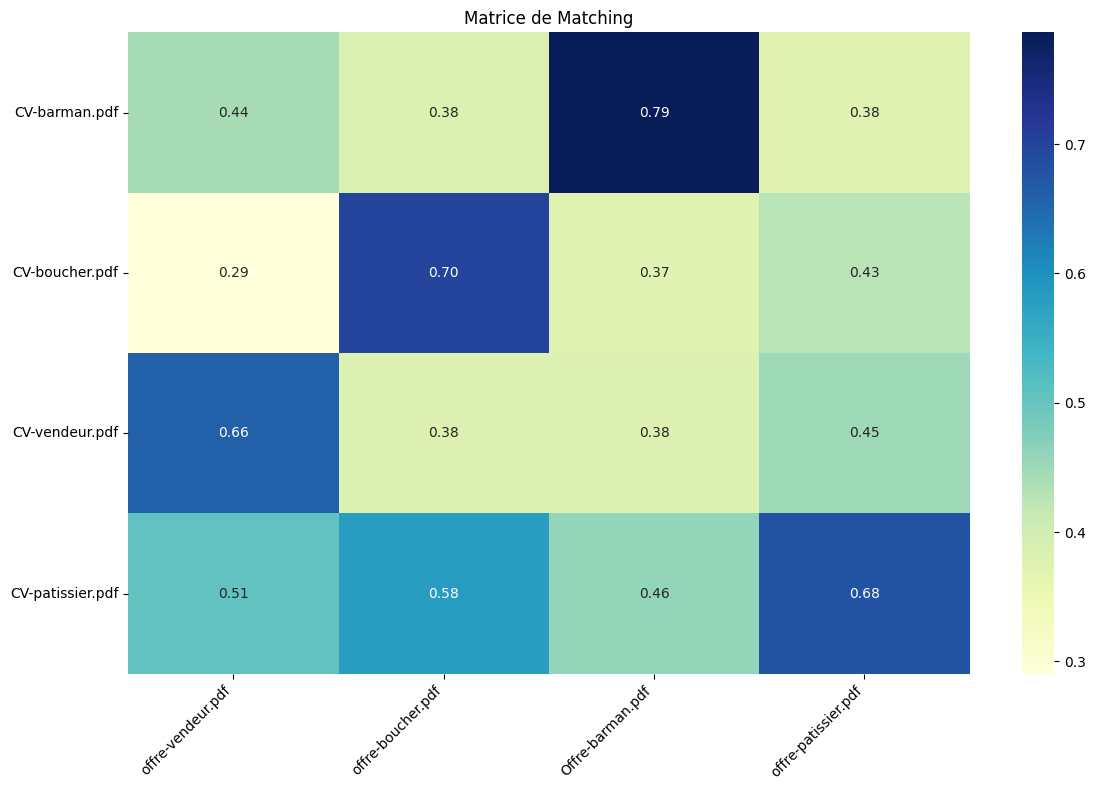

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# On reprend vos calculs de similarité
# similarities = cosine_similarity(emb_cv, emb_offres)

plt.figure(figsize=(12, 8))

# Création de la carte de chaleur
# Plus c'est foncé/rouge, plus le score est haut
sns.heatmap(similarities, 
            annot=True,              # Affiche les chiffres dans les cases
            fmt=".2f",               # 2 chiffres après la virgule
            xticklabels=noms_offres, # Noms des offres en bas
            yticklabels=noms_cv,     # Noms des CVs à gauche
            cmap="YlGnBu")           # Couleurs (Jaune -> Vert -> Bleu)

plt.title("Matrice de Matching")
plt.xticks(rotation=45, ha='right') # Pencher les noms pour lire
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

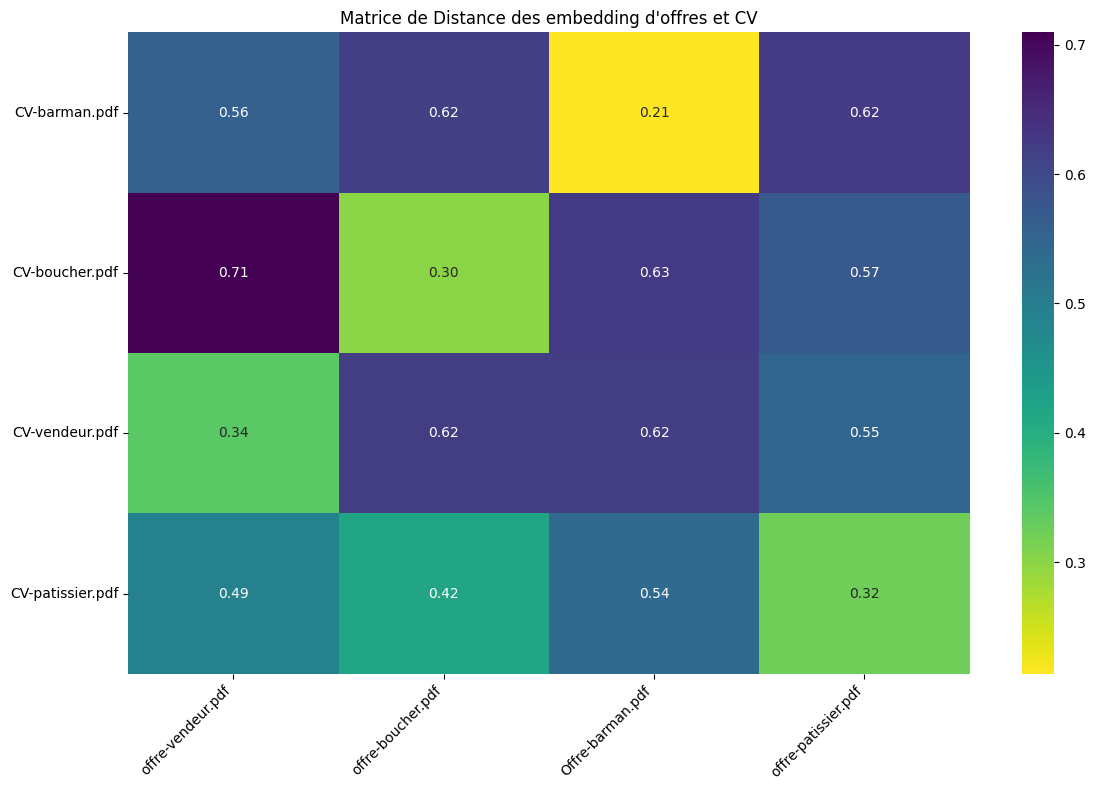

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# 1. Calcul de la Matrice de DISTANCE
# On spécifie metric='cosine'. 
# Sklearn va calculer : Distance = 1 - Cosine_Similarity
# Résultat : 0 = Identique (Match parfait), 1 = Opposé (Aucun rapport)
dist_matrix = pairwise_distances(emb_cv, emb_offres, metric='cosine')

# 2. Affichage
plt.figure(figsize=(12, 8))

# Note sur les couleurs (cmap) :
# J'utilise "r" (reverse) à la fin de "viridis_r" pour que :
# - COULEUR FONCÉE = Distance Faible (0) -> C'est un BON MATCH
# - COULEUR CLAIRE = Distance Élevée (1) -> C'est un MAUVAIS MATCH
sns.heatmap(dist_matrix, 
            annot=True, 
            fmt=".2f", 
            xticklabels=noms_offres, 
            yticklabels=noms_cv, 
            cmap="viridis_r") 

plt.title("Matrice de Distance des embedding d'offres et CV")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

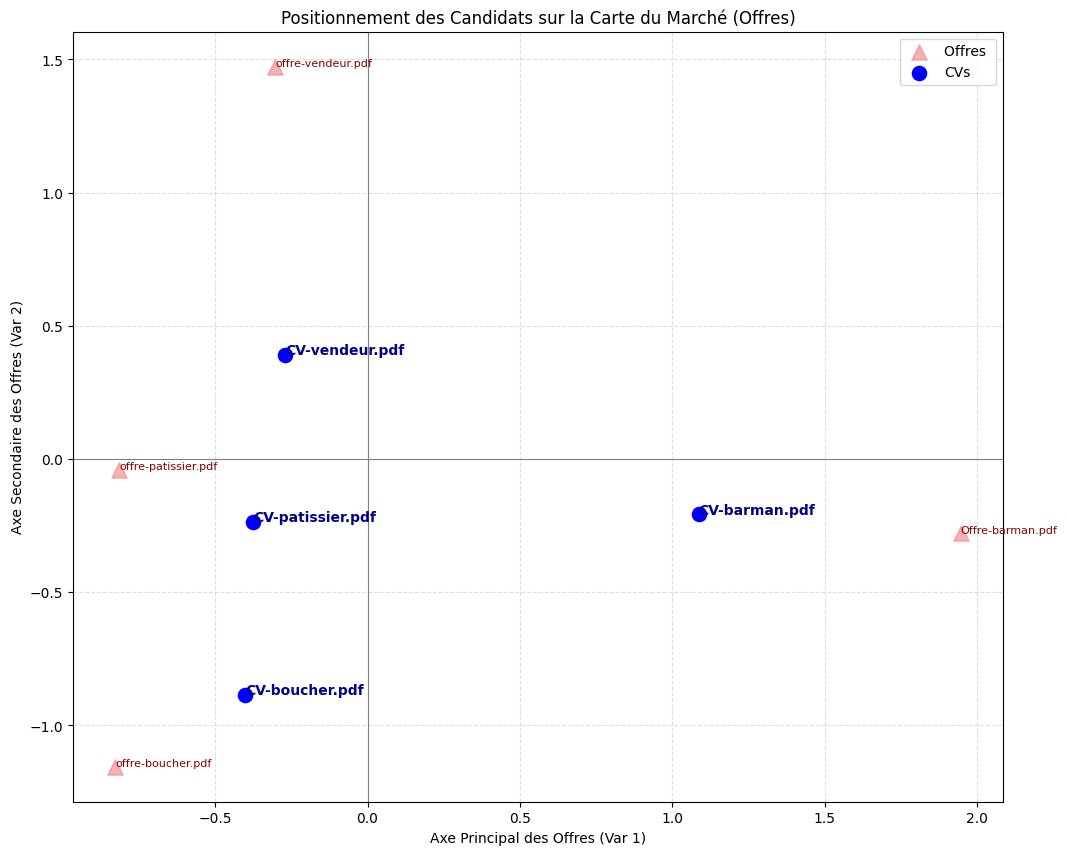

In [57]:
# 1. Initialisation de la PCA
pca = PCA(n_components=2)

# Espace des offres 
pca.fit(emb_offres) 
pca_offres = pca.transform(emb_offres)

# On projette les CVs dans cet espace en supplémentaire
pca_cv = pca.transform(emb_cv)


plt.figure(figsize=(12, 10))

#Affichage des Offres 
plt.scatter(pca_offres[:, 0], pca_offres[:, 1], c='lightcoral', marker='^', s=120, label='Offres ', alpha=0.6)
for i, txt in enumerate(noms_offres):
    plt.annotate(txt, (pca_offres[i, 0], pca_offres[i, 1]), fontsize=8, color='darkred') #texte 

# Affichage des CVs 
plt.scatter(pca_cv[:, 0], pca_cv[:, 1], c='blue', marker='o', s=150, label='CVs', edgecolors='white')
for i, txt in enumerate(noms_cv):
    plt.annotate(txt, (pca_cv[i, 0], pca_cv[i, 1]), fontsize=10, fontweight='bold', color='darkblue')

plt.title("Positionnement des Candidats sur la Carte du Marché (Offres)")
plt.xlabel("Axe Principal des Offres (Var 1)")
plt.ylabel("Axe Secondaire des Offres (Var 2)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Ligne optionnelle : centrer le graphique sur l'origine pour mieux voir
plt.axhline(0, color='grey', linewidth=0.8)
plt.axvline(0, color='grey', linewidth=0.8)

plt.show()

In [56]:
import numpy as np
import pandas as pd

##Génération des fichiers pour TensorFlow Projector...")

# ÉTAPE 1 : Fusionner les vecteurs (Empiler les CVs au-dessus des Offres)
# Cela crée une seule matrice géante
all_vectors = np.vstack((emb_cv, emb_offres))

# ÉTAPE 2 : Créer les métadonnées (Noms + Type)
# On combine les listes de noms
all_names = noms_cv + noms_offres

# On crée une colonne "Type" pour pouvoir colorier différemment sur le site
# Ex: ['CV', 'CV', ..., 'Offre', 'Offre']
all_types = ['CV'] * len(noms_cv) + ['Offre'] * len(noms_offres)

# ÉTAPE 3 : Sauvegarder les fichiers

# 1. Sauvegarder les vecteurs (vectors.tsv)
np.savetxt('vectors.tsv', all_vectors, delimiter='\t')

# 2. Sauvegarder les métadonnées (metadata.tsv)
df_meta = pd.DataFrame({
    'Nom': all_names,
    'Type': all_types  # Cette colonne est cruciale pour la visualisation
})
df_meta.to_csv('metadata.tsv', sep='\t', index=False)

print("✅ Fichiers générés : 'vectors.tsv' et 'metadata.tsv'")

✅ Fichiers générés : 'vectors.tsv' et 'metadata.tsv'
